In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    print("NLTK data downloaded successfully!")
except Exception as e:
    print(f"NLTK download error: {e}")

NLTK data downloaded successfully!


In [5]:
def clean_arabic_english_text(text):
    """
    Clean text with Arabic and English mixed content
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    text = text.replace('â€œ', '"').replace('â€', '"').replace('â€™', "'")
    text = text.replace('â€¦', '...').replace('â€‌', ' ')
    text = text.replace('Ø§Ù„', 'ال')  # Fix Arabic encoding
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = text.lower()
    
    text = re.sub(r'[^\w\s\u0600-\u06FF:;=\-\)\(\[\]{}]', ' ', text)
    
    return text

def tokenize_and_process(text):
    """
    Tokenize and process text (works for English)
    """
    try:
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens 
                 if token not in stop_words and len(token) > 2]
        return ' '.join(tokens)
    except:
        return text

print("Text preprocessing functions defined!")

Text preprocessing functions defined!


In [7]:
try:
    twitter_df = pd.read_csv('DATA/Uneeq_sentiment/Twitter_Data.csv')
    print(f"Twitter data loaded successfully!")
    print(f"Shape: {twitter_df.shape}")
    print(f"Columns: {twitter_df.columns.tolist()}")
    print(f"First few rows:")
    print(twitter_df.head())
    print(f"\nSentiment distribution in Twitter data:")
    print(twitter_df['category'].value_counts())
except Exception as e:
    print(f"Error loading Twitter data: {e}")
    twitter_df = None

print("\n" + "="*50 + "\n")

try:
    reddit_df = pd.read_csv('DATA/Uneeq_sentiment/Reddit_Data.csv')
    print(f"Reddit data loaded successfully!")
    print(f"Shape: {reddit_df.shape}")
    print(f"Columns: {reddit_df.columns.tolist()}")
    print(f"First few rows:")
    print(reddit_df.head())
    print(f"\nSentiment distribution in Reddit data:")
    print(reddit_df['category'].value_counts())
except Exception as e:
    print(f"Error loading Reddit data: {e}")
    reddit_df = None

Twitter data loaded successfully!
Shape: (162980, 2)
Columns: ['clean_text', 'category']
First few rows:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

Sentiment distribution in Twitter data:
category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


Reddit data loaded successfully!
Shape: (37249, 2)
Columns: ['clean_comment', 'category']
First few rows:
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only

In [9]:
if twitter_df is not None:
    print("Processing Twitter data...")
    
    twitter_processed = twitter_df.copy()
    
    twitter_processed['cleaned_text'] = twitter_processed['clean_text'].apply(clean_arabic_english_text)
    
    twitter_processed['processed_text'] = twitter_processed['cleaned_text'].apply(tokenize_and_process)
    
    twitter_processed = twitter_processed[twitter_processed['processed_text'].str.len() > 0]
    
    twitter_processed['text_length'] = twitter_processed['processed_text'].str.len()
    twitter_processed['word_count'] = twitter_processed['processed_text'].str.split().str.len()
    
    label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    twitter_processed['sentiment_label'] = twitter_processed['category'].map(label_mapping)
    
    print(f"Twitter data processed!")
    print(f"Shape after processing: {twitter_processed.shape}")
    print(f"Sample processed text:")
    print(twitter_processed[['clean_text', 'processed_text', 'sentiment_label']].head())
else:
    twitter_processed = None

Processing Twitter data...
Twitter data processed!
Shape after processing: (162909, 7)
Sample processed text:
                                          clean_text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

                                      processed_text sentiment_label  
0  modi promised minimum government maximum gover...        negative  
1             talk nonsense continue drama vote modi         neutral  
2  say vote modi welcome bjp told rahul main camp...        positive  
3  asking supporter prefix chowkidar name modi gr...        positive  
4  answer among powerful world leader today trump...        positive  


In [11]:
if reddit_df is not None:
    print("Processing Reddit data...")
    
    reddit_processed = reddit_df.copy()
    
    reddit_processed['cleaned_text'] = reddit_processed['clean_comment'].apply(clean_arabic_english_text)
    
    reddit_processed['processed_text'] = reddit_processed['cleaned_text'].apply(tokenize_and_process)
    
    reddit_processed = reddit_processed[reddit_processed['processed_text'].str.len() > 0]
    
    reddit_processed['text_length'] = reddit_processed['processed_text'].str.len()
    reddit_processed['word_count'] = reddit_processed['processed_text'].str.split().str.len()
    
    label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    reddit_processed['sentiment_label'] = reddit_processed['category'].map(label_mapping)
    
    print(f"Reddit data processed!")
    print(f"Shape after processing: {reddit_processed.shape}")
    print(f"Sample processed text:")
    print(reddit_processed[['clean_comment', 'processed_text', 'sentiment_label']].head())
else:
    reddit_processed = None

Processing Reddit data...
Reddit data processed!
Shape after processing: (36915, 7)
Sample processed text:
                                       clean_comment  \
0   family mormon have never tried explain them t...   
1  buddhism has very much lot compatible with chr...   
2  seriously don say thing first all they won get...   
3  what you have learned yours and only yours wha...   
4  for your own benefit you may want read living ...   

                                      processed_text sentiment_label  
0  family mormon never tried explain still stare ...        positive  
1  buddhism much lot compatible christianity espe...        positive  
2  seriously say thing first get complex explain ...        negative  
3  learned want teach different focus goal wrappi...         neutral  
4  benefit may want read living buddha living chr...        positive  


=== TWITTER DATA ANALYSIS ===
Total Twitter samples: 162909
Average text length: 95.73
Average word count: 14.32


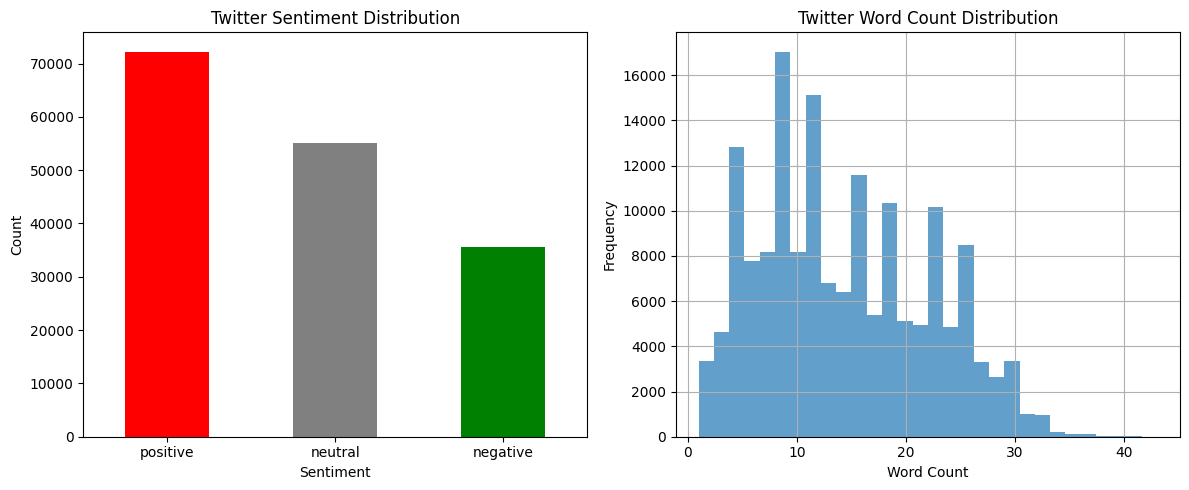

In [13]:
if twitter_processed is not None:
    print("=== TWITTER DATA ANALYSIS ===")
    
    print(f"Total Twitter samples: {len(twitter_processed)}")
    print(f"Average text length: {twitter_processed['text_length'].mean():.2f}")
    print(f"Average word count: {twitter_processed['word_count'].mean():.2f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    twitter_processed['sentiment_label'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
    plt.title('Twitter Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    twitter_processed['word_count'].hist(bins=30, alpha=0.7)
    plt.title('Twitter Word Count Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

=== REDDIT DATA ANALYSIS ===
Total Reddit samples: 36915
Average text length: 133.28
Average word count: 19.61


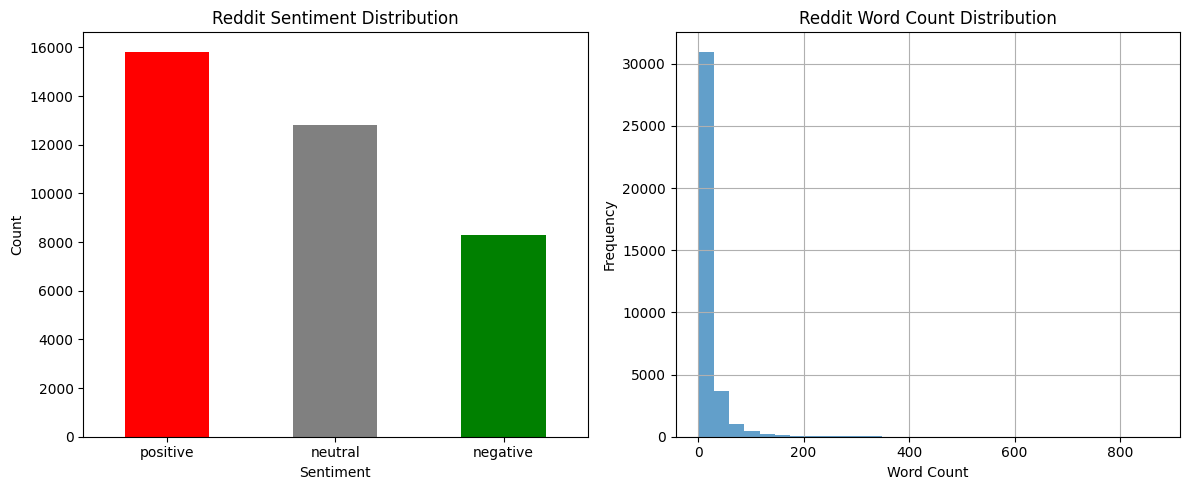

In [15]:
if reddit_processed is not None:
    print("=== REDDIT DATA ANALYSIS ===")
    
    print(f"Total Reddit samples: {len(reddit_processed)}")
    print(f"Average text length: {reddit_processed['text_length'].mean():.2f}")
    print(f"Average word count: {reddit_processed['word_count'].mean():.2f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    reddit_processed['sentiment_label'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
    plt.title('Reddit Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    reddit_processed['word_count'].hist(bins=30, alpha=0.7)
    plt.title('Reddit Word Count Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [17]:
combined_data = []

if twitter_processed is not None:
    twitter_subset = twitter_processed[['processed_text', 'category', 'sentiment_label']].copy()
    twitter_subset['source'] = 'twitter'
    combined_data.append(twitter_subset)

if reddit_processed is not None:
    reddit_subset = reddit_processed[['processed_text', 'category', 'sentiment_label']].copy()
    reddit_subset['source'] = 'reddit'
    combined_data.append(reddit_subset)

if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Combined sentiment distribution:")
    print(combined_df['sentiment_label'].value_counts())
    print(f"Source distribution:")
    print(combined_df['source'].value_counts())
else:
    combined_df = None
    print("No data available for combination")

Combined dataset shape: (199824, 4)
Combined sentiment distribution:
sentiment_label
positive    88072
neutral     67962
negative    43783
Name: count, dtype: int64
Source distribution:
source
twitter    162909
reddit      36915
Name: count, dtype: int64


In [19]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Get VADER sentiment scores"""
    scores = sia.polarity_scores(text)
    return scores

if twitter_processed is not None:
    print("Applying VADER to Twitter data...")
    vader_scores_twitter = []
    for text in twitter_processed['clean_text']:
        scores = get_vader_sentiment(text)
        vader_scores_twitter.append(scores)
    
    twitter_processed['vader_compound'] = [s['compound'] for s in vader_scores_twitter]
    twitter_processed['vader_sentiment'] = twitter_processed['vader_compound'].apply(
        lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
    )
    
    print("VADER analysis complete for Twitter!")

if reddit_processed is not None:
    print("Applying VADER to Reddit data...")
    vader_scores_reddit = []
    for text in reddit_processed['clean_comment']:
        scores = get_vader_sentiment(text)
        vader_scores_reddit.append(scores)
    
    reddit_processed['vader_compound'] = [s['compound'] for s in vader_scores_reddit]
    reddit_processed['vader_sentiment'] = reddit_processed['vader_compound'].apply(
        lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
    )
    
    print("VADER analysis complete for Reddit!")

Applying VADER to Twitter data...
VADER analysis complete for Twitter!
Applying VADER to Reddit data...
VADER analysis complete for Reddit!


In [21]:
if combined_df is not None:
    ml_data = combined_df.dropna()
    print("Using combined dataset for ML training")
elif twitter_processed is not None:
    ml_data = twitter_processed[['processed_text', 'category', 'sentiment_label']].copy()
    print("Using Twitter dataset for ML training")
elif reddit_processed is not None:
    ml_data = reddit_processed[['processed_text', 'category', 'sentiment_label']].copy()
    print("Using Reddit dataset for ML training")
else:
    ml_data = None
    print("No data available for ML training")

if ml_data is not None:
    X = ml_data['processed_text']
    y = ml_data['category']  
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Training set sentiment distribution:")
    print(pd.Series(y_train).value_counts())

Using combined dataset for ML training
Training set size: 159853
Test set size: 39964
Training set sentiment distribution:
category
 1.0    70457
 0.0    54370
-1.0    35026
Name: count, dtype: int64


In [23]:
if ml_data is not None:
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english'
    )
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
    print("TF-IDF vectorization completed!")

TF-IDF feature matrix shape: (159853, 10000)
TF-IDF vectorization completed!


In [25]:
if ml_data is not None:
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    trained_models = {}
    print("Training models...")
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_tfidf, y_train)
        trained_models[name] = model
        print(f"{name} training completed!")
    
    print("All models trained successfully!")

Training models...
Training Logistic Regression...
Logistic Regression training completed!
Training Naive Bayes...
Naive Bayes training completed!
Training Random Forest...
Random Forest training completed!
All models trained successfully!


In [27]:
if ml_data is not None:
    results = {}
    
    print("Evaluating models...")
    print("="*50)
    
    for name, model in trained_models.items():
        # Make predictions
        y_pred = model.predict(X_test_tfidf)
        y_prob = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else None
        
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
        print("-" * 30)

Evaluating models...

Logistic Regression Results:
Accuracy: 0.8503
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.73      0.78      8757
     Neutral       0.81      0.94      0.87     13592
    Positive       0.89      0.84      0.86     17615

    accuracy                           0.85     39964
   macro avg       0.85      0.84      0.84     39964
weighted avg       0.85      0.85      0.85     39964

------------------------------

Naive Bayes Results:
Accuracy: 0.7043
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.46      0.59      8757
     Neutral       0.76      0.66      0.70     13592
    Positive       0.65      0.86      0.74     17615

    accuracy                           0.70     39964
   macro avg       0.74      0.66      0.68     39964
weighted avg       0.72      0.70      0.70     39964

------------------------------

Random Forest Results:

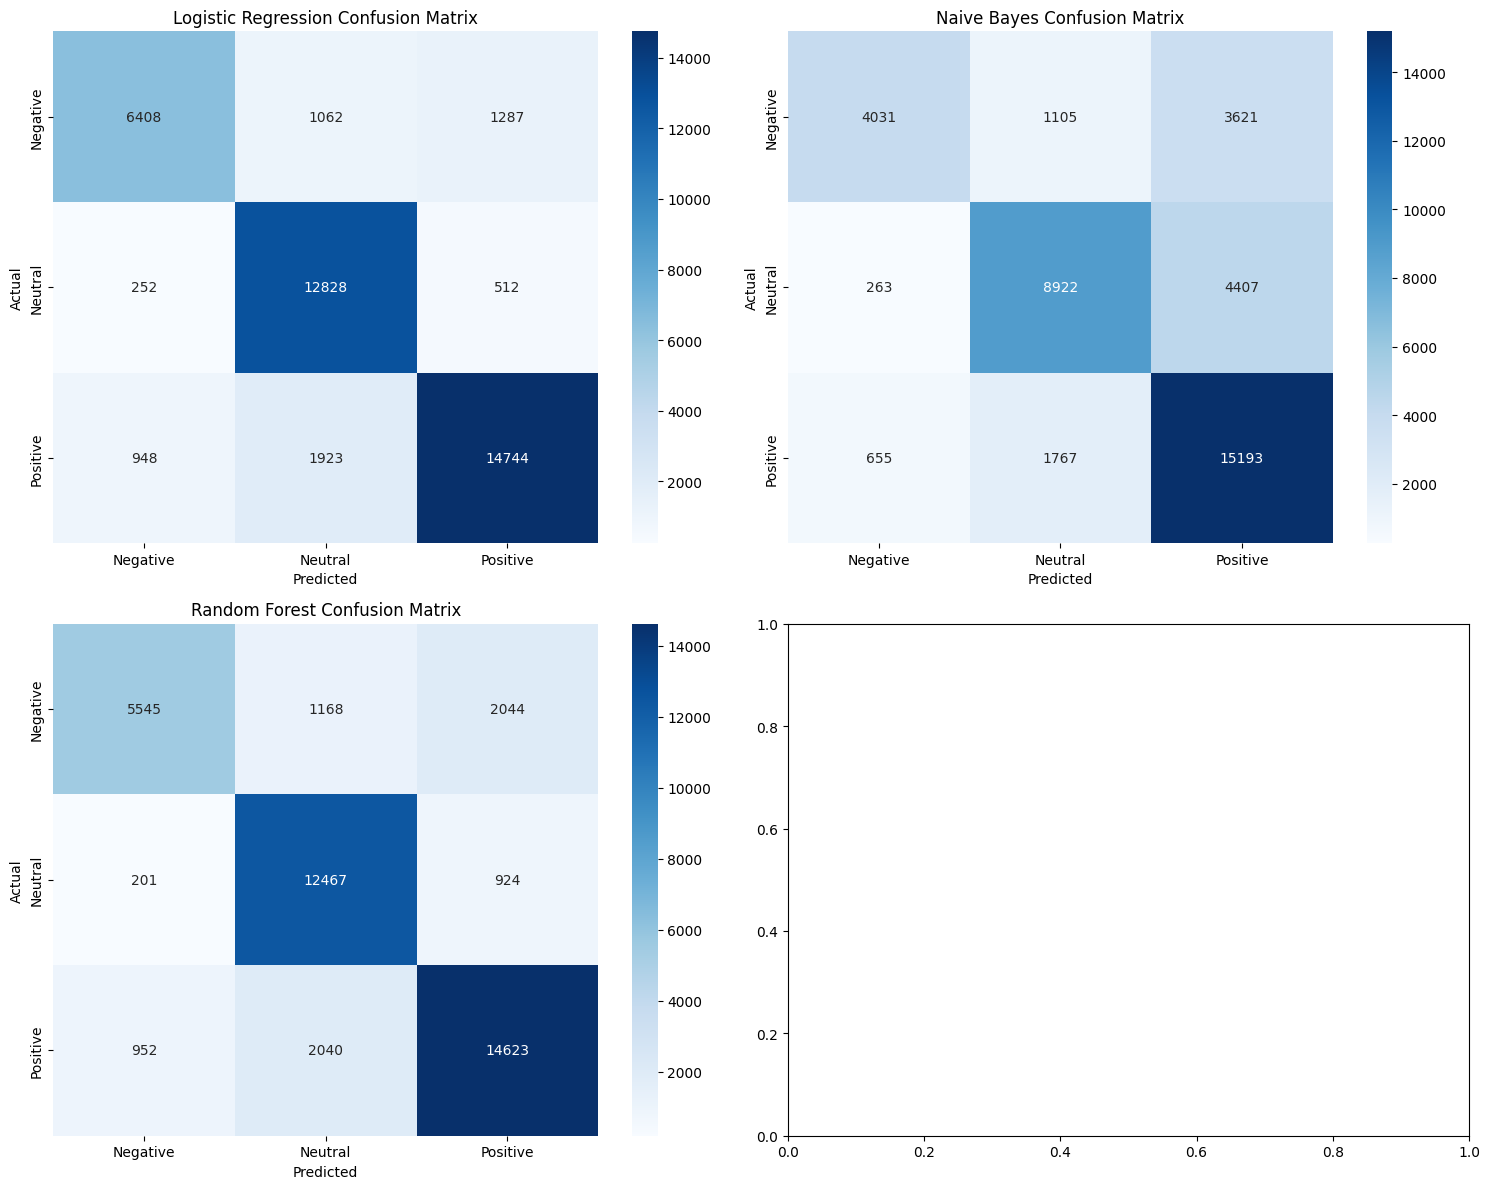

In [29]:
if ml_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(trained_models.items()):
        y_pred = results[name]['predictions']
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Neutral', 'Positive'],
                   yticklabels=['Negative', 'Neutral', 'Positive'],
                   ax=axes[idx])
        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

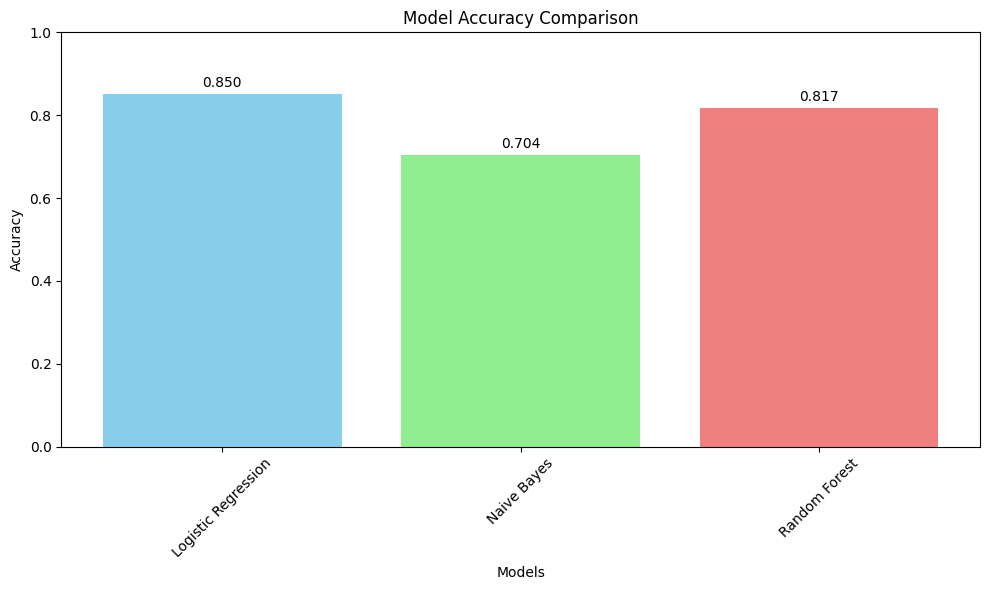

Best Model: Logistic Regression with accuracy: 0.8503


In [31]:
if ml_data is not None:
    model_accuracies = {name: results[name]['accuracy'] for name in results.keys()}
    
    plt.figure(figsize=(10, 6))
    models_names = list(model_accuracies.keys())
    accuracies = list(model_accuracies.values())
    
    bars = plt.bar(models_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_model_name = max(model_accuracies, key=model_accuracies.get)
    best_accuracy = model_accuracies[best_model_name]
    print(f"Best Model: {best_model_name} with accuracy: {best_accuracy:.4f}")

In [33]:
def predict_sentiment(text, model_name='Logistic Regression'):
    """
    Predict sentiment for new text
    """
    if ml_data is None:
        return "No trained model available"
    
    cleaned_text = clean_arabic_english_text(text)
    processed_text = tokenize_and_process(cleaned_text)
    
    text_tfidf = tfidf_vectorizer.transform([processed_text])
    
    model = trained_models[model_name]
    prediction = model.predict(text_tfidf)[0]
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
        confidence = max(probabilities)
    else:
        confidence = None
    
    vader_scores = get_vader_sentiment(text)
    vader_sentiment = 'positive' if vader_scores['compound'] > 0.05 else 'negative' if vader_scores['compound'] < -0.05 else 'neutral'
    
    label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    predicted_sentiment = label_mapping[prediction]
    
    return {
        'text': text,
        'predicted_sentiment': predicted_sentiment,
        'confidence': confidence,
        'vader_sentiment': vader_sentiment,
        'vader_score': vader_scores['compound']
    }

print("Prediction function defined!")

Prediction function defined!


In [35]:
test_texts = [
    "Modi is doing great work for the country",
    "I don't like the current government policies", 
    "The election results are neutral",
    "This is amazing progress in development",
    "Very disappointed with the recent decisions"
]

print("Testing predictions:")
print("="*60)

for text in test_texts:
    if ml_data is not None:
        result = predict_sentiment(text, best_model_name)
        print(f"Text: {text}")
        print(f"ML Prediction: {result['predicted_sentiment']}")
        if result['confidence']:
            print(f"Confidence: {result['confidence']:.3f}")
        print(f"VADER Prediction: {result['vader_sentiment']}")
        print(f"VADER Score: {result['vader_score']:.3f}")
        print("-" * 40)
    else:
        print("No trained model available for prediction")
        break

Testing predictions:
Text: Modi is doing great work for the country
ML Prediction: positive
Confidence: 0.988
VADER Prediction: positive
VADER Score: 0.625
----------------------------------------
Text: I don't like the current government policies
ML Prediction: neutral
Confidence: 0.670
VADER Prediction: negative
VADER Score: -0.276
----------------------------------------
Text: The election results are neutral
ML Prediction: neutral
Confidence: 0.803
VADER Prediction: neutral
VADER Score: 0.000
----------------------------------------
Text: This is amazing progress in development
ML Prediction: positive
Confidence: 0.987
VADER Prediction: positive
VADER Score: 0.765
----------------------------------------
Text: Very disappointed with the recent decisions
ML Prediction: negative
Confidence: 0.984
VADER Prediction: negative
VADER Score: -0.526
----------------------------------------


In [47]:
predict_sentiment("I hear You" , best_model_name)

{'text': 'I hear You',
 'predicted_sentiment': 'neutral',
 'confidence': 0.6515269696081348,
 'vader_sentiment': 'neutral',
 'vader_score': 0.0}

In [73]:
import joblib
joblib.dump(trained_models[best_model_name],'best_sentiment_model.pkl')
joblib.dump(tfidf_vectorizer,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [75]:
A = joblib.load('best_sentiment_model.pkl')
B = joblib.load('tfidf_vectorizer.pkl')

In [129]:
Text = ["I Love you",
       "I hate you",
       "I hear you"]
X = B.transform(Text)
Pre = A.predict(X)

In [131]:
label_mapping = {
    -1: "Negative",
    0: "Neutral",
    1: "Positive"
}

for text, pred in zip(Text, Pre):
    sentiment = label_mapping.get(pred, "Unknown")
    print(f"Text: {text}\n→ Sentiment: {sentiment}\n")

Text: I Love you
→ Sentiment: Positive

Text: I hate you
→ Sentiment: Negative

Text: I hear you
→ Sentiment: Neutral

